### Importing relevant libraries

In [1]:
from PIL import Image 
import numpy as np
import os
from os import listdir
from PIL import Image 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings('ignore')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Loading labels

In [2]:
df= pd.read_csv('train.csv')
df

,id,label
0,0,24
1,1,2
2,2,17
3,3,14
4,4,19
...,...,...
13435,13435,5
13436,13436,26
13437,13437,2
13438,13438,24


In [3]:
labels= df['label']

In [4]:
labels.shape

(13440,)

In [25]:
l=labels-1

In [26]:
l.max()

27

In [27]:
l.min()

0

### Loading images

In [5]:
train_path="C:\\Users\\mady\\Epita\\OCR\\train\\"
test_path="C:\\Users\\mady\\Epita\\OCR\\test\\"

In [6]:
def loadImages(path):
    # return array of images
    
    imagesList = listdir(path)
    image_df = []
    for image in imagesList:
        img = Image.open(path + image).convert('L')
        img=img.resize((32,32))
        img=np.asarray(img)
        img=img.reshape((32,32,1))
        img=img/255
        image_df.append(img)
    
    return np.array(image_df)

In [7]:
train_data = loadImages(train_path)
test_data= loadImages(test_path)

In [8]:
train_data.shape

(13440, 32, 32, 1)

In [9]:
test_data.shape

(3360, 32, 32, 1)

### Visualizing some images

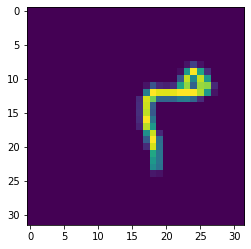

In [10]:
plt.imshow(train_data[0])

### Shuffling images

In [11]:
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)
shuffled_images = train_data[indices]
shuffled_labels = labels[indices]


### Dividing data into train/validation/test

In [12]:
validation_samples= int(0.1*train_data.shape[0])    #nearly 10%
test_samples = int(0.1*train_data.shape[0])        #nearly 10%    
train_samples = train_data.shape[0]-(validation_samples+test_samples)      #nearly 80%


In [13]:
validation_images= shuffled_images[:validation_samples]
validation_labels= shuffled_labels[:validation_samples]

test_images = shuffled_images[validation_samples:validation_samples+test_samples]
test_labels= shuffled_labels[validation_samples:validation_samples+test_samples]


train_images = shuffled_images[validation_samples+test_samples:]
train_labels = shuffled_labels[validation_samples+test_samples:]



In [14]:
train_images.shape

(10752, 32, 32, 1)

In [15]:
validation_images.shape

(1344, 32, 32, 1)

In [16]:
test_images.shape

(1344, 32, 32, 1)

### Model outline

In [151]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(64,3,activation='relu',input_shape=(32,32,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,'relu'),
#     tf.keras.layers.Dense(128,'relu'),

#     tf.keras.layers.Dense(100,'relu'),
    tf.keras.layers.Dense(29)
    
    
])                                

### Model architecture

In [152]:
model.summary(line_length=75)

Model: "sequential_15"
___________________________________________________________________________
Layer (type)                     Output Shape                  Param #     
conv2d_26 (Conv2D)               (None, 30, 30, 64)            640         
___________________________________________________________________________
max_pooling2d_24 (MaxPooling2D)  (None, 15, 15, 64)            0           
___________________________________________________________________________
conv2d_27 (Conv2D)               (None, 13, 13, 64)            36928       
___________________________________________________________________________
max_pooling2d_25 (MaxPooling2D)  (None, 6, 6, 64)              0           
___________________________________________________________________________
flatten_15 (Flatten)             (None, 2304)                  0           
___________________________________________________________________________
dense_35 (Dense)                 (None, 128)                   29

### Compiling our model

In [153]:
loss_fn= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [154]:
model.compile(optimizer='adam',loss=loss_fn,metrics=['accuracy'])

### Defining early stopping technique

In [155]:
early_stopping=tf.keras.callbacks.EarlyStopping(
monitor='val_loss',
mode='auto',
min_delta=0,
patience=2,
verbose=0,
restore_best_weights=True)

### Fitting our model

In [160]:
model.fit(
    train_images,
    train_labels,
    epochs=100,
    batch_size=1024,
    callbacks=[early_stopping],
    validation_data= (validation_images,validation_labels),
    verbose=2
)

Epoch 1/100
11/11 - 4s - loss: 0.0572 - accuracy: 0.9896 - val_loss: 0.2987 - val_accuracy: 0.9040
Epoch 2/100
11/11 - 4s - loss: 0.0554 - accuracy: 0.9895 - val_loss: 0.3004 - val_accuracy: 0.9048
Epoch 3/100
11/11 - 4s - loss: 0.0538 - accuracy: 0.9890 - val_loss: 0.3008 - val_accuracy: 0.9055


In [161]:
model.evaluate(test_images,test_labels)

42/42 [==============================] - 0s 5ms/step - loss: 0.3582 - accuracy: 0.9077


[0.35822877287864685, 0.9077380895614624]

### Generating predictions

In [185]:
predictions= model.predict(test_data)

In [186]:
predictions

array([[-26.988398  , -26.09919   , -13.764016  , ...,  18.581097  ,
          4.62803   ,  -3.4238904 ],
       [-14.572941  ,  -4.2888365 ,  -3.4508126 , ...,  -2.5110266 ,
          2.38784   ,  -3.678976  ],
       [-25.28751   ,  26.505962  ,  -3.5646892 , ..., -14.901378  ,
          1.8279961 , -10.093289  ],
       ...,
       [-18.637848  , -23.173082  ,  -3.574599  , ...,  -9.038627  ,
        -15.517454  ,  -1.4109501 ],
       [-28.90252   ,  -6.8226237 , -13.845346  , ...,  -7.7403684 ,
          0.34811535, -11.526544  ],
       [-25.091755  , -31.701567  ,  -4.2782297 , ...,  -7.6657014 ,
        -14.309497  ,  -3.6787732 ]], dtype=float32)

In [187]:
predictions= np.argmax(predictions,axis=1)

In [188]:
predictions.shape

(3360,)

In [189]:
test_df= pd.read_csv('test.csv')

In [190]:
test_df

,id
0,0
1,1
2,2
3,3
4,4
...,...
3355,3355
3356,3356
3357,3357
3358,3358


In [191]:
preds= pd.DataFrame()
preds['id']= test_df['id']
preds['label']= predictions

### Exporting to csv

In [192]:
preds.to_csv('submission.csv',index=False)